### Importações

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

from sklearn.neighbors import LocalOutlierFactor

In [2]:
%reload_ext autoreload
sys.path.append(os.path.abspath('..'))
from functions.clean_df import load_and_combine_csvs,clean_dataframe,add_confidential_flags
from functions.state_imput import apply_state_estimation
from functions.feature_engineering import feature_engineering
from functions.preprocessing_lof import get_preprocessor_lof
from functions.models import run_lof

### Criar o DF

In [3]:
raw_path = '../raw_data/'
df_raw = load_and_combine_csvs(raw_path)

df_clean = clean_dataframe(df_raw)

df_clean = add_confidential_flags(df_clean)
df_clean = apply_state_estimation(df_clean)
df_clean = feature_engineering(df_clean)

### Feature Engeniering necessárias para o LOF

In [4]:
## Frequência das categorias
cols_categoria = ['NOME ÓRGÃO', 'ESTADO_ESTIMADO', 'NOME FAVORECIDO']

for col in cols_categoria:
    freq_map = df_clean[col].value_counts(normalize=True)
    df_clean[f'FREQ_{col}'] = df_clean[col].map(freq_map)

In [5]:
# Média por Órgão no MÊS
df_clean['MEDIA_VALOR_ORGAO_MES'] = df_clean.groupby(['NOME ÓRGÃO', 'ANO EXTRATO', 'MÊS EXTRATO'])['VALOR TRANSAÇÃO'].transform('mean')

# Razão do valor da transação pela média do órgão no período
df_clean['RATIO_MES'] = df_clean['VALOR TRANSAÇÃO'] / df_clean['MEDIA_VALOR_ORGAO_MES']

### Selecionando as features e processando os dados

In [6]:
features_modelo = [
    'LOG_VALOR',
    'RATIO_MES',
    'ANO EXTRATO',
    'MÊS EXTRATO',
    'FREQ_NOME ÓRGÃO',
    'FREQ_ESTADO_ESTIMADO',
    'SIGILOSO',
    'FIM_SEMANA'
]

# Criando X
X = df_clean[features_modelo].copy().fillna(0)

In [7]:
preprocessor = get_preprocessor_lof()
X_scaled = preprocessor.fit_transform(df_clean)

ruido = np.random.normal(0, 1e-5, X_scaled.shape)
X_final_lof = X_scaled + ruido

### Treinando o modelo

In [8]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, n_jobs=-1)

# Fit / Predict
df_clean['LOF_LABEL'] = lof.fit_predict(X_final_lof)
df_clean['LOF_SCORE'] = lof.negative_outlier_factor_

### Visualização

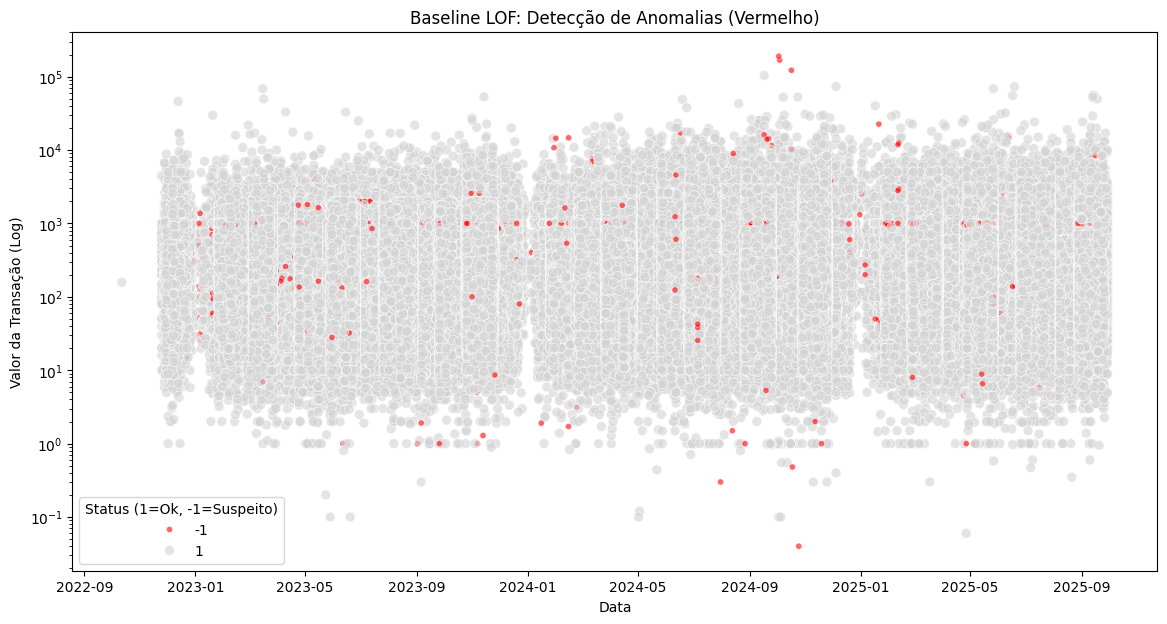

In [9]:
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df_clean,
    x='DATA TRANSAÇÃO',
    y='VALOR TRANSAÇÃO',
    hue='LOF_LABEL',
    palette={1: 'lightgrey', -1: 'red'},
    alpha=0.6,
    size='LOF_LABEL',
    sizes=(20, 50)
)
plt.yscale('log')
plt.title('Baseline LOF: Detecção de Anomalias (Vermelho)')
plt.ylabel('Valor da Transação (Log)')
plt.xlabel('Data')
plt.legend(title='Status (1=Ok, -1=Suspeito)')
plt.show()

### Top suspeitos

In [10]:
cols_view = ['NOME ÓRGÃO', 'NOME FAVORECIDO', 'VALOR TRANSAÇÃO', 'DATA TRANSAÇÃO', 'ESTADO_ESTIMADO', 'LOF_SCORE']
top_anomalias = df_clean[df_clean['LOF_LABEL'] == -1].sort_values('LOF_SCORE', ascending=True).head(10)
top_anomalias.head(100)[cols_view]

,NOME ÓRGÃO,NOME FAVORECIDO,VALOR TRANSAÇÃO,DATA TRANSAÇÃO,ESTADO_ESTIMADO,LOF_SCORE
100402,Ministério do Meio Ambiente e Mudança do Clima...,NAO SE APLICA,1000.0,2023-01-05,UNIÃO,-39199.494347
281933,Presidência da República,NAO SE APLICA,1000.0,2023-12-20,PR,-15677.763494
136991,"VALEC Engenharia, Construções e Ferrovias S.A.",NAO SE APLICA,600.0,2024-12-20,UNIÃO,-15569.799308
100403,Ministério do Meio Ambiente e Mudança do Clima...,NAO SE APLICA,500.0,2023-01-05,UNIÃO,-14553.290117
136992,"VALEC Engenharia, Construções e Ferrovias S.A.",NAO SE APLICA,400.0,2024-12-20,UNIÃO,-11845.634293
134634,Instituto Chico Mendes de Conservação da Biodi...,NAO SE APLICA,60.0,2024-12-02,SE,-11333.532563
261865,Ministério da Defesa - Unidades com vínculo di...,NAO SE APLICA,1000.0,2023-08-09,UNIÃO,-7066.956042
261889,Ministério da Defesa - Unidades com vínculo di...,NAO SE APLICA,1000.0,2023-08-21,UNIÃO,-7066.947909
370287,"Instituto Federal de Educação, Ciência e Tecno...",NAO SE APLICA,1000.0,2022-11-30,ES,-6836.856642
370289,"Instituto Federal de Educação, Ciência e Tecno...",NAO SE APLICA,1000.0,2022-11-29,ES,-6836.591350


### Teste da função

In [11]:
df_final = run_lof(df_clean)

In [12]:
df_final.head()

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,...,ID_PORTADOR,FIM_SEMANA,LOG_VALOR,FREQ_NOME ÓRGÃO,FREQ_ESTADO_ESTIMADO,FREQ_NOME FAVORECIDO,MEDIA_VALOR_ORGAO_MES,RATIO_MES,LOF_LABEL,LOF_SCORE
0,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.562.861-**,ANTONIO CARLOS MELO DOS SANTOS,...,***.562.861-**ANTONIO CARLOS MELO DOS SANTOS,0,7.208600,0.006521,0.216305,0.000003,303.736923,4.444636,1,-1.042711
1,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.562.861-**,ANTONIO CARLOS MELO DOS SANTOS,...,***.562.861-**ANTONIO CARLOS MELO DOS SANTOS,0,5.099866,0.006521,0.216305,0.000072,303.736923,0.536649,1,-1.026614
2,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.562.861-**,ANTONIO CARLOS MELO DOS SANTOS,...,***.562.861-**ANTONIO CARLOS MELO DOS SANTOS,0,5.755742,0.006521,0.216305,0.000003,303.736923,1.037082,1,-1.009249
3,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.866.951-**,JONAS SCHOTTZ DA SILVA,...,***.866.951-**JONAS SCHOTTZ DA SILVA,0,4.259859,0.006521,0.216305,0.000117,303.736923,0.229804,1,-1.001874
4,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.523.712-**,SORAYA RITA DO AMARAL GARCIA VIANNA,...,***.523.712-**SORAYA RITA DO AMARAL GARCIA VIANNA,0,6.552508,0.006521,0.216305,0.000488,303.736923,2.304626,1,-1.018893
